## Stacked Convolutional and Recurrent Neural Networks for Audio Classification

<img style="float:center" width=200 src="figures/CRNN_tampere.png">

## Convolutional Neural Networks

In [1]:
# FIX ALL THE RANDOM VALUES TO GET REPRODUCIBLE RESULTS
import os
os.environ["PYTHONHASHSEED"] = "0"

import random as rn
rn.seed(1254)

import numpy as np
np.random.seed(1515)

# SET NICE PLOTTING
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import librosa, librosa.display, IPython.display as ipd
from tqdm import tqdm
import glob
import pandas as pd
import h5py
from sklearn import preprocessing
import pickle

In [2]:
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

import tensorflow as tf
tf.set_random_seed(2)

config = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1 
)

config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(graph= tf.get_default_graph(), config=config) 
    
import keras 
from keras import backend as K
K.set_session(sess)  # set this TensorFlow session as the default session for Keras

from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
from keras.layers.core import Dropout
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [4]:
#SET PATHS
workspace = '/vol/vssp/AcousticEventsDetection/DLGdansk/UrbanSound/'

hdf5_path = os.path.join(workspace,'dataset.hdf5') 
modelfolder = os.path.join(workspace,'models')
scalerpath = os.path.join(workspace,'scaler.pkl')

In [5]:
# LOAD DATA
hf = h5py.File(hdf5_path, 'r')
X_train = np.array(hf.get('X_train') )
y_train = np.array(hf.get('y_train'))
X_val =  np.array(hf.get('X_val'))
y_val= np.array(hf.get('y_val'))
X_test = np.array(hf.get('X_test'))
y_test = np.array(hf.get('y_test'))

n_features= hf.get('n_features').value
n_frames=hf.get('max_length_samp').value
label_list= hf.get('label_list').value

In [6]:
# SCALE THE DATA
scaler=pickle.load(open(scalerpath, 'rb'))

X_train_scaled = [scaler.transform(x.T) for x in X_train]
X_val_scaled = [scaler.transform(x.T) for x in X_val]
X_test_scaled = [scaler.transform(x.T) for x in X_test]

# CHANGE DIMENSION TO FIT KERAS
X_train = np.expand_dims(X_train_scaled, 3)
X_val = np.expand_dims(X_val_scaled, 3)
X_test = np.expand_dims(X_test_scaled, 3)

In [7]:
def build_cnn(n_frames=n_frames, n_features=n_features,  n_filters_cnn=48,
                     filter_size_cnn=(3, 3), pool_size=(2,2),
                     n_classes=10):

    # INPUT
    x = Input(shape=(n_frames, n_features,  1), dtype='float32')

    # CONV 1
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid', 
               kernel_regularizer=l2(0.01), activation='relu')(x)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 2
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',
               kernel_regularizer=l2(0.01), activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # CONV 3
    y = Conv2D(n_filters_cnn, filter_size_cnn, padding='valid',
               kernel_regularizer=l2(0.01), activation='relu')(y)
    y = MaxPooling2D(pool_size=pool_size, strides=None, padding='valid')(y)
    y = BatchNormalization()(y)

    # Flatten for dense layers
    y = Flatten()(y)

    y = Dropout(0.5)(y)
    y = Dense(n_classes, activation='sigmoid')(y)

    m = Model(inputs=x, outputs=y)
    return m

In [8]:
m = build_cnn(n_features=40,)
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 173, 40, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 171, 38, 48)       480       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 19, 48)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 19, 48)        192       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 83, 17, 48)        20784     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 8, 48)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 8, 48)         192       
__________

In [9]:
from keras.utils import plot_model
plot_model(m, to_file='figures/cnn_model_shape.png', show_shapes=True)

<img width = 300 src='figures/cnn_model_shape.png'>

In [10]:
m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_checkpoint = ModelCheckpoint(
                 os.path.join(modelfolder, 
                        'cnn_epoch_{epoch:03d}_val_loss_{val_loss:.4f}.hdf5'),
                 monitor='val_loss', 
                 save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
callbacks = [early_stopping, model_checkpoint]

In [11]:
history = m.fit(x=X_train, y=y_train, batch_size=130,
                    epochs=200, verbose=True,
                    validation_split=0.0,                
                    callbacks=callbacks,
                    validation_data=(X_val, y_val), shuffle=True)

Train on 7079 samples, validate on 7079 samples
Epoch 1/200
7079/7079 [==============================] - 6s 877us/step - loss: 2.6058 - acc: 0.3619 - val_loss: 2.9741 - val_acc: 0.1913
Epoch 2/200
7079/7079 [==============================] - 4s 568us/step - loss: 1.9554 - acc: 0.5405 - val_loss: 3.3440 - val_acc: 0.1182
Epoch 3/200
7079/7079 [==============================] - 4s 559us/step - loss: 1.5459 - acc: 0.6611 - val_loss: 3.2514 - val_acc: 0.1247
Epoch 4/200
7079/7079 [==============================] - 4s 543us/step - loss: 1.2856 - acc: 0.7337 - val_loss: 3.3344 - val_acc: 0.1315
Epoch 5/200
7079/7079 [==============================] - 4s 579us/step - loss: 1.0743 - acc: 0.7930 - val_loss: 3.2732 - val_acc: 0.1867
Epoch 6/200
7079/7079 [==============================] - 4s 579us/step - loss: 0.9248 - acc: 0.8233 - val_loss: 3.4218 - val_acc: 0.2140
Epoch 7/200
7079/7079 [==============================] - 4s 585us/step - loss: 0.8087 - acc: 0.8524 - val_loss: 2.7948 - val_acc: 

7079/7079 [==============================] - 4s 572us/step - loss: 0.2507 - acc: 0.9689 - val_loss: 0.2742 - val_acc: 0.9595
Epoch 61/200
7079/7079 [==============================] - 4s 575us/step - loss: 0.2728 - acc: 0.9602 - val_loss: 0.2618 - val_acc: 0.9651
Epoch 62/200
7079/7079 [==============================] - 4s 549us/step - loss: 0.2844 - acc: 0.9593 - val_loss: 0.2376 - val_acc: 0.9787
Epoch 63/200
7079/7079 [==============================] - 4s 578us/step - loss: 0.2731 - acc: 0.9650 - val_loss: 0.2162 - val_acc: 0.9819
Epoch 64/200
7079/7079 [==============================] - 4s 531us/step - loss: 0.2427 - acc: 0.9730 - val_loss: 0.2243 - val_acc: 0.9770
Epoch 65/200
7079/7079 [==============================] - 4s 574us/step - loss: 0.2305 - acc: 0.9744 - val_loss: 0.1836 - val_acc: 0.9914
Epoch 66/200
7079/7079 [==============================] - 4s 574us/step - loss: 0.2476 - acc: 0.9681 - val_loss: 0.2388 - val_acc: 0.9703
Epoch 67/200
7079/7079 [=======================

7079/7079 [==============================] - 4s 576us/step - loss: 0.2235 - acc: 0.9747 - val_loss: 0.1959 - val_acc: 0.9816
Epoch 179/200
7079/7079 [==============================] - 4s 536us/step - loss: 0.1937 - acc: 0.9843 - val_loss: 0.1529 - val_acc: 0.9959
Epoch 180/200
7079/7079 [==============================] - 4s 557us/step - loss: 0.1916 - acc: 0.9825 - val_loss: 0.1813 - val_acc: 0.9849
Epoch 181/200
7079/7079 [==============================] - 4s 524us/step - loss: 0.1923 - acc: 0.9819 - val_loss: 0.1848 - val_acc: 0.9830
Epoch 182/200
7079/7079 [==============================] - 4s 551us/step - loss: 0.2216 - acc: 0.9723 - val_loss: 0.1832 - val_acc: 0.9870
Epoch 183/200
7079/7079 [==============================] - 4s 550us/step - loss: 0.2228 - acc: 0.9725 - val_loss: 0.1743 - val_acc: 0.9894
Epoch 184/200
7079/7079 [==============================] - 4s 560us/step - loss: 0.2188 - acc: 0.9746 - val_loss: 0.1629 - val_acc: 0.9945
Epoch 185/200
7079/7079 [================

Text(0,0.5,u'Loss')

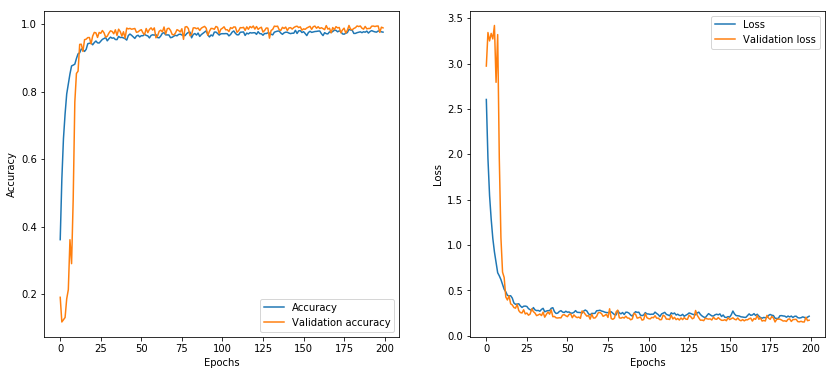

In [33]:
plt.subplot(1,2,1)
plt.plot(history.history['acc'], label='Accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [12]:
prediction = m.predict(X_test, batch_size=130, verbose=1)
y_predict=np.array([ np.argmax(p) for p in prediction])
y_test_label = np.array([np.argmax(y) for y in y_test])

837/837 [==============================] - 0s 359us/step


Accuracy: 0.73


Text(0.5,32.0938,u'Predicted label')

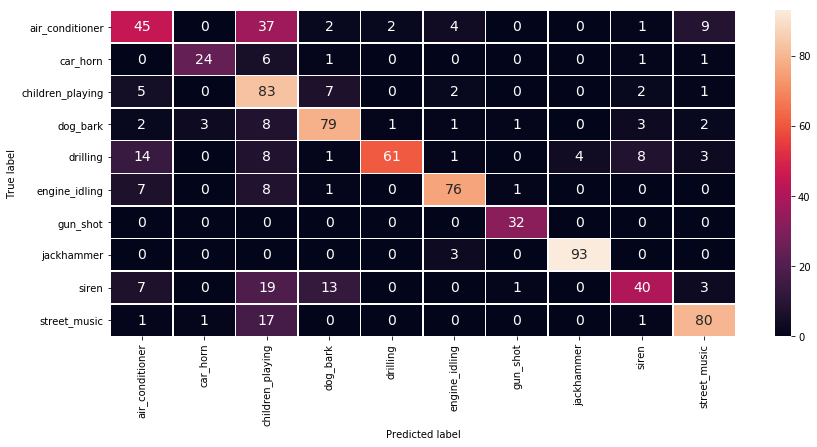

In [35]:
from sklearn.metrics import confusion_matrix
acc = np.sum(y_test_label==y_predict) / float(len(y_test_label))
print('Accuracy: {:.2f}'.format(acc))

cm = confusion_matrix(y_test_label, y_predict )
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, fmt='g', linewidths=.5, 
            yticklabels=label_list,xticklabels=label_list)
plt.ylabel('True label')
plt.xlabel('Predicted label')